In [ ]:
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxsc
stock_data = yf.download('AMZN', start='2010-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.812500,6.830500,6.657000,6.695000,6.695000,151998000
2010-01-05,6.671500,6.774000,6.590500,6.734500,6.734500,177038000
2010-01-06,6.730000,6.736500,6.582500,6.612500,6.612500,143576000
2010-01-07,6.600500,6.616000,6.440000,6.500000,6.500000,220604000
2010-01-08,6.528000,6.684000,6.451500,6.676000,6.676000,196610000
...,...,...,...,...,...,...
2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700
2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000
2022-12-28,82.800003,83.480003,81.690002,81.820000,81.820000,58228600


In [ ]:
def computersi(data, window=14):
    delta =data['Close'].diff()
    gain =(delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss=(-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs =gain/loss
    rsi =100-(100/(1+ rs))
    return rsi
stock_data['RSI'] = computersi(stock_data)
stock_data = stock_data.dropna() 

In [ ]:
sc=MinMaxsc()
scdata = sc.fit_transform(stock_data[['Close', 'RSI']])
def createseq(data, timesteps=1):
    X, y=[], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps)])
        y.append(data[i + timesteps, 0])  # Predicting 'Close'
    return np.array(X), np.array(y)
timesteps = 10
X, y = createseq(scdata, timesteps)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
Xtraintensor=torch.tensor(X_train, dtype=torch.float32)
ytraintensor=torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_testtens=torch.tensor(X_test, dtype=torch.float32)
y_testtens=torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm=nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc=nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ =self.lstm(x)
        out=self.fc(out[:, -1, :])  
        return out

In [ ]:
model=LSTMModel(input_size=2, hidden_size=80, num_layers=2)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 90
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(Xtraintensor)
    loss = criterion(outputs, ytraintensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/90], Loss: 0.0299
Epoch [20/90], Loss: 0.0231
Epoch [30/90], Loss: 0.0050
Epoch [40/90], Loss: 0.0012
Epoch [50/90], Loss: 0.0012
Epoch [60/90], Loss: 0.0006
Epoch [70/90], Loss: 0.0003
Epoch [80/90], Loss: 0.0002
Epoch [90/90], Loss: 0.0002


In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_testtens)
    predictions = predictions.numpy()
predictions = sc.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:, 0]

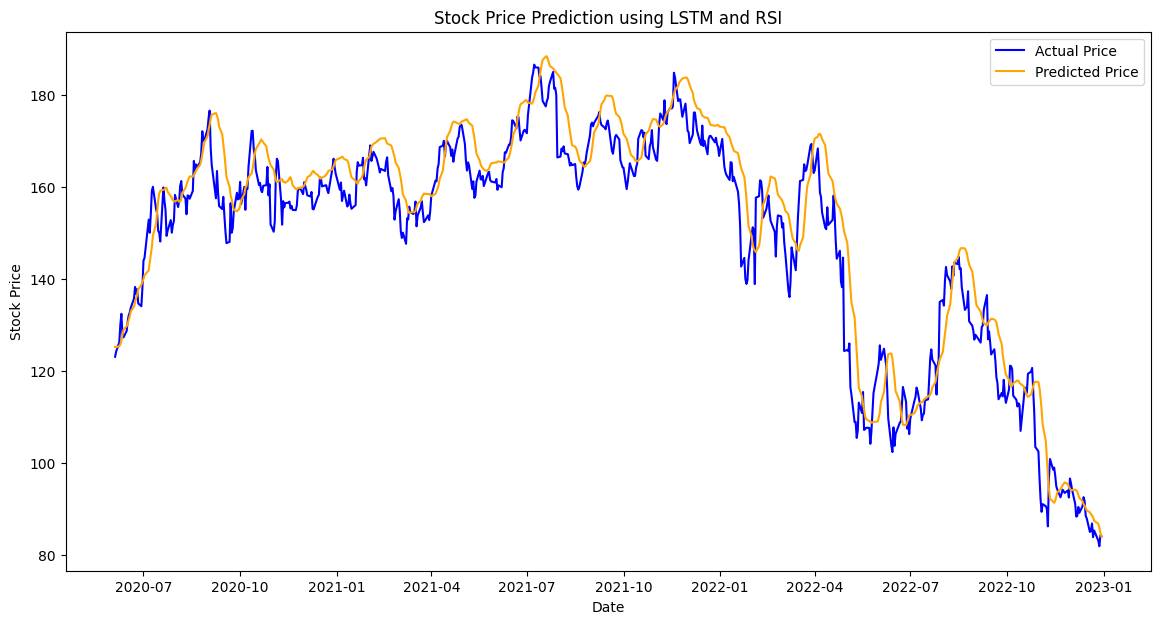

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[train_size + timesteps:], stock_data['Close'][train_size + timesteps:], label='Actual Price', color='blue')
plt.plot(stock_data.index[train_size + timesteps:], predictions, label='Predicted Price', color='orange')
plt.title('Stock Price Prediction using LSTM and RSI')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

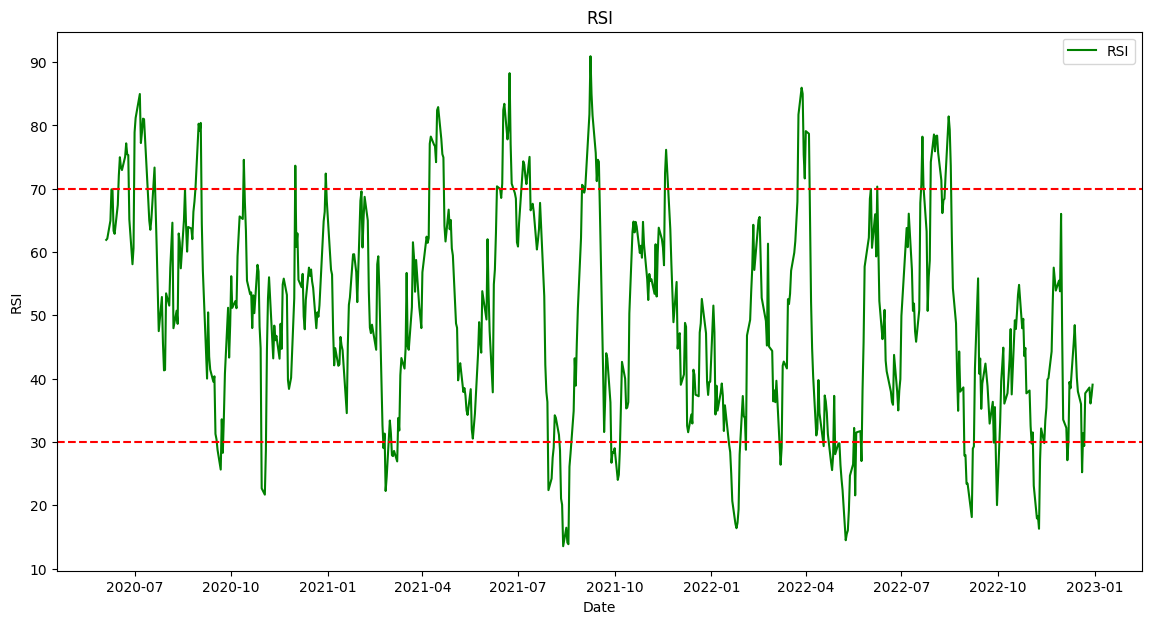

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[train_size + timesteps:], stock_data['RSI'][train_size + timesteps:], label='RSI', color='green')
plt.axhline(y=30, color='r', linestyle='--')
plt.axhline(y=70, color='r', linestyle='--')
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()